In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

import os
from PIL import Image
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

# **PART 1.0 - DATA PREPROCESSING**

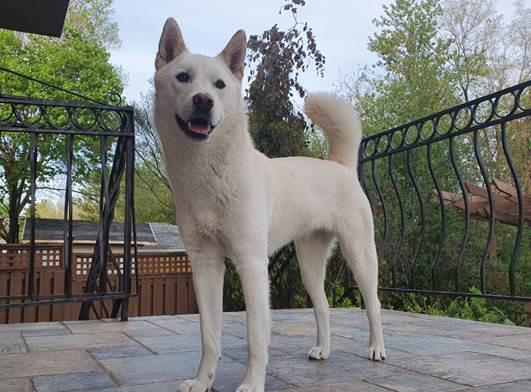

In [5]:
with Image.open('9374.jpg') as im:
  display(im) #showing a sample dog image from the dataset

In [ ]:
path = 'CATS_DOGS\\' #path right before the train test split
img_names =[] #creating an empty list to take in all the image names

for folder,subfolders,filenames in os.walk(path):
  for img in filenames:
    img_names.append(folder+'/'+img)

print('There are',len(img_names),'images')
print(img_names[-1])

In [7]:
img_sizes = []
rejected = []

for item in img_names:
  try:
    with Image.open(item) as img:
      img_sizes.append(img.size)

  except:
    rejected.append(item)

print(len(img_sizes))
print(len(rejected))  

24994
0


In [7]:
df = pd.DataFrame(img_sizes)
df.head() #column 0 is width, column 1 is height of the image size

,0,1
0,431,360
1,500,375
2,500,471
3,500,375
4,320,240


In [8]:
df[0].describe() #so width is from 42 to 500 pixels, with a mean of 404, so not too many small images. This will help us decide an input size for our CNN

count    24994.000000
mean       404.493518
std        108.941802
min         42.000000
25%        323.000000
50%        448.000000
75%        500.000000
max        500.000000
Name: 0, dtype: float64

In [9]:
df[1].describe() #so height is from 33 to 500, with a mean of 361, so not too many small images. This will help us decide an input size for our CNN

count    24994.000000
mean       361.037129
std         96.936811
min         33.000000
25%        302.000000
50%        375.000000
75%        421.000000
max        500.000000
Name: 1, dtype: float64

# 1.1 Transforming for Training

In [8]:
#Transforming our data into a tensor, along with a uniform size, implementing random flips/rotations, and normalizing to actually feed into our training data
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees = 117),
    transforms.Resize((224,224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),     
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])          
])

In [9]:
#For the next set, we don't need to do the random flips or rotation, since we're just testing and not training
test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),     
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])          
])

In [10]:
train_data = datasets.ImageFolder(root = 'CATS_DOGS\\train', transform = train_transform) #pointing the path to the training data and applying the transform made above
test_data = datasets.ImageFolder(root = 'CATS_DOGS\\test', transform = test_transform) #pointing the path to the training data and applying the transform made above

train_loader = DataLoader(train_data, batch_size=10, shuffle = True) #so now we're loading in the data from the CAT-DOG training Dataset, and we only load it in in batches of 10 rows at a time out of the 60000 images, with the rows being shuffled (random) 
test_loader = DataLoader(test_data, batch_size = 10, shuffle = False)

class_names = train_data.classes
print(class_names) #Notice the two classes are CAT and DOG, based on the folder titles

['CAT', 'DOG']


In [35]:
print(len(train_data))
print(len(test_data))

18743
6251


In [36]:
for images,labels in train_loader:
  # this for loop will happen 18743 times
  #so for the sake of an example, say we break out of this for loop after the first batch
  break

print(labels)
print(labels.shape)
print(images.shape) #notice how it's a 4D tensor with the first element being batch size = 10, colour channels = 3, and 224x224 is the size of the image

tensor([0, 0, 1, 1, 1, 0, 1, 0, 1, 1])
torch.Size([10])
torch.Size([10, 3, 224, 224])


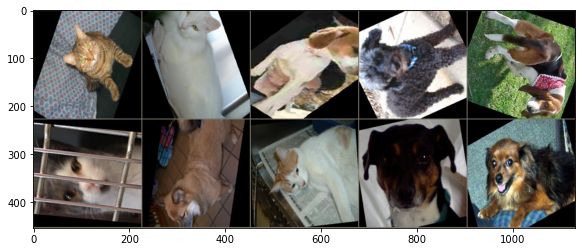

In [37]:
im = make_grid(tensor = images, nrow = 5)

#Can reverse the normalization by dividing the means by the standard deviation, as well as getting the 1/standard deviation
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

# **PART 2 - CNN CLASS**

In [26]:
#DETERMINING FLATTENED LAYER
x = images
print(x.shape) #the shape before we do anything

conv1 = nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)  #1 colour channel, 8 filters, size of filters are 3x3, and 1 is stride
conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, stride = 1, padding = 1) #8 input filtersfrom Convl, 16 filters, size of filters are 3x3, and 1 is stride
x = F.relu(conv1(x)) #feeding x through the first convolution layer
print("x shape after conv1 =", x.shape)
x = F.max_pool2d(x, kernel_size = 2, stride = 2)
print("x shape after pool1 =", x.shape)
x = F.relu(conv2(x)) #feeding x through the second convolution layer
print("x shape after conv2 =", x.shape)
x = F.max_pool2d(x, kernel_size = 2, stride = 2)
print("x shape after pool2 =", x.shape)
print("Flattened x =",x.view(10,-1).shape) #so when we flatten it, this would be the final shape of x, except batch size will be 10 instead of 1

torch.Size([10, 3, 224, 224])
x shape after conv1 = torch.Size([10, 8, 224, 224])
x shape after pool1 = torch.Size([10, 8, 112, 112])
x shape after conv2 = torch.Size([10, 16, 112, 112])
x shape after pool2 = torch.Size([10, 16, 56, 56])
Flattened x = torch.Size([10, 50176])


In [27]:
# (originl size - 2 if padding)/2 if pooling layer = (224/2)/2 = 56

In [28]:
#The brain will be a CNN
#so here we're using inheritance, which is when we create a class that is a child class of an existing parent class in PyTorch nn called Module. We do this so that we can use all the variables and functions from parent class Module, which will be useful for us when developing our network
class CNN(nn.Module):
    
    #You always start with __init__ to initialize the values when creating a class
    def __init__(self):
        super().__init__() #super is a function that allows us to use Module's functions and variables, while also optimizing this inheritance process
        self.emb_drop = nn.Dropout(0.4) #adding a dropout layer
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)  #this first convolutional layer will apply convolution to the input images (creating a feature map by using a feature detector on the input image). 
        #in_channels and out_channels are the input/output of the convolution respectively. so for our case, in_channels = 3 because we are using coloured images which is RGB (BW channels = 1, cuz no RGB).
        #the out_channels equating to 8 means we created 8 new feature maps using the feature detection process. We chose 8 as it's a common practice and power of 2
        #kernel_size is just the feature detector size, so used the common 5x5 size and will reduce it for the later layers
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, stride = 1, padding = 1)#second convolutional layer undergoing the same feature detection process. input_channel is 8 as it's the output of the last layer. 

        #recall that after the convolutional step (and max pooling), we must flatten our feature map, so that we can use them as inputs in our ANN
        self.fc1 = nn.Linear(in_features = 56*56*16, out_features = 120) #fc1 stands for first full connection. Linear is a inherited class from the nn.Module. 6*6*16 = 576 is the number of input nodes which is the number of pixels from the images that were vectorized by flattening, and 120 is the number of neurons in the hidden layer (which was found from experimentation, but can still be optimized). 
        self.fc2 = nn.Linear(in_features = 120, out_features = 60)  #fc2 stands for second full connection. 120 is the input for this connection, since the last one ended with 120
        self.fc3 = nn.Linear(in_features = 60, out_features = 2)  #fc3 stands for third full connection. 84 is the input for this connection, and the output is the 10 classes from 0 to 9

    #This next function is to create the forward propagations through our NN
    def forward(self, x):
        x = F.relu(self.conv1(x)) #first convolutional layer
        x = F.max_pool2d(x, kernel_size = 2, stride = 2) #first pooling layer
        x = F.relu(self.conv2(x)) #second convolutional layer
        x = F.max_pool2d(x, kernel_size = 2, stride = 2) #second pooling layer
        x = x.view(-1, 56*56*16) #flattening our image data to feed into our ANN now
        x = F.relu(self.fc1(x)) #input layer connected to first hidden layer into our ANN
        x = self.emb_drop(x) #adding the drop out layer
        x = F.relu(self.fc2(x)) #first hidden layer connected to our second hidden layer 
        x = self.emb_drop(x) #adding the drop out layer
        x = F.log_softmax(self.fc3(x), dim = 1) #Use SOFTMAX for >2 (multiclass) categorical problems where the answer is mutually exclusive (so only one correct output out of multiple options).
        return x

In [29]:
model = CNN()
model

CNN(
  (emb_drop): Dropout(p=0.4, inplace=False)
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=50176, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (fc3): Linear(in_features=60, out_features=2, bias=True)
)

In [30]:
criterion = nn.CrossEntropyLoss() #so our loss measurement will be based off CrossEntropyLoss since this is a mutually exclusive answer (only 1 target can be correct)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) #model parameters are just the fully connected layers and we are using Adam optimizer to optimize them
model.parameters #can see the parameters are just the fully connected layers and we are optimizing them

<bound method Module.parameters of CNN(
  (emb_drop): Dropout(p=0.4, inplace=False)
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=50176, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (fc3): Linear(in_features=60, out_features=2, bias=True)
)>

In [31]:
# We want to use CNN is cuz our number of parameters is less
for param in model.parameters():
  print(param.numel()) #print number of elements in param
  #if you sum this all up, we have 107990 total parameters that are being adjusted. This is almost the same as the ANN model for MNIST had which was 105214, but this CIFAR is larger images AND contains a colour channel

216
8
1152
16
6021120
120
7200
60
120
2


In [ ]:
import time #Gonna try to keep track of how long it takes to train our model

start_time = time.time()

epochs = 20

#Trackers for visualization
train_losses = []
test_losses = []
train_correct = []
test_correct = []

#This for loop trains our NN
for i in range(epochs):
  #Forward propagation through our ANN using training data
  train_corr = 0
  test_corr = 0

  for b, (X_train, y_train) in enumerate(train_loader):
    #b = batches and enumerate just counts what batch number we're on with b, and basically using tuple unpacking to get the X_train and y_train
    b += 1
    y_pred = model.forward(x = X_train) #recall in ANN we had to flatten the images in this step, but now that we're using CNN, it's already done for us in the class CNN

    #Calculating loss/error
    loss = criterion(y_pred, y_train)

    predicted = torch.max(y_pred.data,1)[1] #so recall we have 10 output neurons providing a probability on what they think the answer to the image is. Here we are grabbing the highest probabilty along the column axis = 1, and indexing it to get the actual predicted value
    batch_corr = (predicted == y_train).sum() #summing how many we got correct
    train_corr += batch_corr #adding to the train_corr 

    #Backpropagation
    optimizer.zero_grad() #resetting the gradient on the optimizer so it doesn't accumulate
    loss.backward() #doing backpropagation off the loss function
    optimizer.step() #using the optimizer for the back propagation

    if b%400 == 0:
      acc = train_corr.item()*10/(100*b)
      print(f'Epoch {i}    batch{b}    loss:{loss.item()}    accuracy: {acc} ')
    
  train_losses.append(loss)
  train_correct.append(train_corr)

  with torch.no_grad():
    for b, (X_test, y_test) in enumerate(test_loader):
      y_val = model.forward(x = X_test) #recall in ANN we had to flatten the images in this step, but now that we're using CNN, it's already done for us in the class CNN
      predicted = torch.max(y_val.data,1)[1] #so recall we have 10 output neurons providing a probability on what they think the answer to the image is. Here we are grabbing the highest probabilty along the column axis = 1, and indexing it to get the actual predicted value
      test_corr += (predicted == y_test).sum() #summing how many we got correct

  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(test_corr)

print(f'Training took {(time.time() - start_time)/60} minutes')

In [ ]:
torch.save(model.state_dict(), 'myCNNmodel.pt')

# **PART 3 - CNN EVALUATION**

In [ ]:
#Plotting our error
plt.plot(train_losses,label = 'Training Loss')
plt.plot(test_losses, label = 'Test/Validation Loss')
plt.ylabel('Cross Entropy LOSS')
plt.xlabel('Epoch') 
plt.legend()

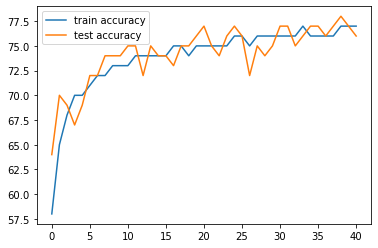

In [18]:
test_acc = [t//62.6 for t in test_correct] #62.5 = 625 batches per epoch / 10 batch size
train_acc = [t//187.5 for t in train_correct] #187.5 = 1875 batches per epoch / 10 batch size

plt.plot(train_acc, label = 'train accuracy')
plt.plot(test_acc, label = 'test accuracy')
plt.legend()

In [19]:
# NEW UNSEEN DATA

test_load_all = DataLoader(test_data, batch_size = 10000, shuffle = False)

#This just turns off the backpropagation, so we can use the model for evaluation rather than training. This helps reduce memory usage and computation speed
with torch.no_grad():
  correct = 0

  for X_test, y_test in test_load_all:
    y_val = model.forward(x = X_test) 
    predicted = torch.max(y_val, 1)[1] #so recall we have 10 output neurons providing a probability on what they think the answer to the image is. Here we are grabbing the highest probabilty along the column axis = 1, and indexing it to get the actual predicted value
    correct += (predicted == y_test).sum() #summing how many we got correct

print('Total accuracy on Test Set = ', correct.item()/len(test_data)*100, '%')

Total accuracy on Test Set =  76.59574468085107 %


In [20]:
confusion_matrix(predicted.view(-1), y_test.view(-1))

array([[2238,  575],
       [ 888, 2550]], dtype=int64)

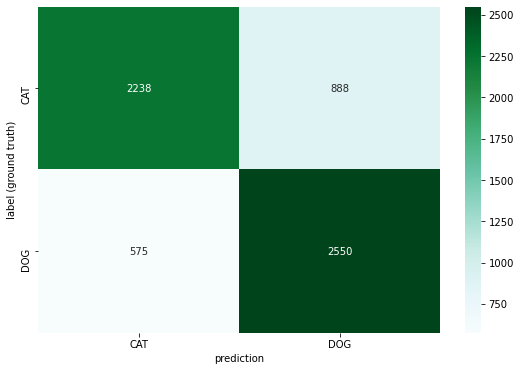

In [21]:
arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();
#notice how cats are more often get mistake for a dog, than dogs do for cats